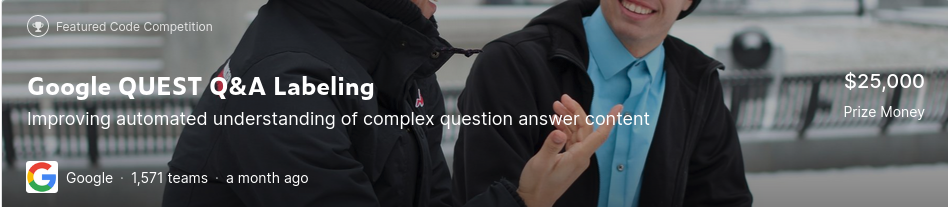

In [10]:
from IPython.display import Image

Datapath = Path('/home/wyquek/Documents/Kaggle/GoogleQUESTQ&ALabeling')
Image(Datapath/"Image/googlequest_header.png")

Computers are really good at answering questions with single, verifiable answers. But, humans are often still better at answering questions about opinions, recommendations, or personal experiences.

Humans are better at addressing subjective questions that require a deeper, multidimensional understanding of context - something computers aren't trained to do well…yet.. Questions can take many forms - some have multi-sentence elaborations, others may be simple curiosity or a fully developed problem. They can have multiple intents, or seek advice and opinions. Some may be helpful and others interesting. Some are simple right or wrong. 

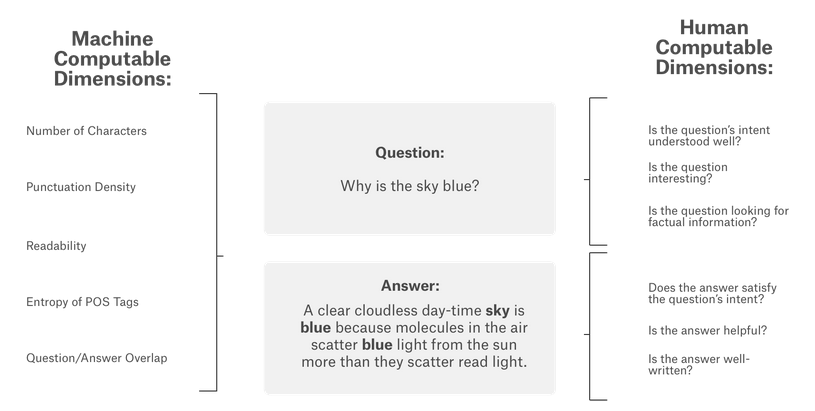

In [11]:
Image(Datapath/"Image/diagram.png")

Unfortunately, it’s hard to build better subjective question-answering algorithms because of a lack of data and predictive models. That’s why the CrowdSource team at Google Research, a group dedicated to advancing NLP and other types of ML science via crowdsourcing, has collected data on a number of these quality scoring aspects.

In this competition, you’re challenged to use this new dataset to build predictive algorithms for different subjective aspects of question-answering. The question-answer pairs were gathered from nearly 70 different websites, in a "common-sense" fashion. Our raters received minimal guidance and training, and relied largely on their subjective interpretation of the prompts. As such, each prompt was crafted in the most intuitive fashion so that raters could simply use their common-sense to complete the task. By lessening our dependency on complicated and opaque rating guidelines, we hope to increase the re-use value of this data set. What you see is what you get!

Demonstrating these subjective labels can be predicted reliably can shine a new light on this research area. Results from this competition will inform the way future intelligent Q&A systems will get built, hopefully contributing to them becoming more human-like.

In [1]:
from fastai2.basics import *
from fastai2.text.all import *
from fastai2.callback.all import *
import json
from typing import *
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
from transformers import AlbertForSequenceClassification, AlbertTokenizer, AlbertConfig
%matplotlib inline

# DATA

In [2]:
Datapath = Path('/home/wyquek/Documents/Kaggle/GoogleQUESTQ&ALabeling')

In [3]:
train = pd.read_csv(Datapath/"Data"/"train.csv")
train.head(3).T

,0,1,2
qa_id,0,1,2
question_title,What am I losing when using extension tubes instead of a macro lens?,What is the distinction between a city and a sprawl/metroplex... between downtown and a commercial district?,Maximum protusion length for through-hole component pins
question_body,"After playing around with macro photography on-the-cheap (read: reversed lens, rev. lens mounted on a straight lens, passive extension tubes), I would like to get further with this. The problems with the techniques I used is that focus is manual and aperture control is problematic at best. This limited my setup to still subjects (read: dead insects) Now, as spring is approaching, I want to be able to shoot live insects. I believe that for this, autofocus and settable aperture will be of great help.\n\nSo, one obvious but expensive option is a macro lens (say, EF 100mm Macro) However, I am ...","I am trying to understand what kinds of places the spam values on p 231 refer to in the 5th Edition main book for Shadowrun.\n\nPer p 15, a sprawl is a plex, a plex is a ""metropolitan complex, short for metroplex"". Per Google a metroplex is "" a very large metropolitan area, especially one that is an aggregation of two or more cities"". A city downtown and sprawl downtown would tend to have similar densities, but for some reason the sprawl (which includes suburbs?) has a higher spam zone noise rating (p 231). Similarly, I'd think of a downtown as being more dense and noisy (e.g. Office bui...","I'm working on a PCB that has through-hole components on both sides of the board. The ""top"" side of the board is mounted flush to a Delrin plastic block (the only top-side component is a gas sensor that is fed air samples through hose fittings in the plastic block).\n\nThe flush mounting means that I have to add grooves to the plastic block to accommodate the soldered pins of the bottom-side components. Assuming a standard 0.062"" thickness FR4 board, how deep do I need to make the grooves in the plastic block? The only thing I could find is this NASA workmanship standard that states 0.5mm ..."
question_user_name,ysap,russellpierce,Joe Baker
question_user_page,https://photo.stackexchange.com/users/1024,https://rpg.stackexchange.com/users/8774,https://electronics.stackexchange.com/users/10157
answer,"I just got extension tubes, so here's the skinny.\n\n\n ...what am I losing when using tubes...?\n\n\nA very considerable amount of light! Increasing that distance from the end of the lens to the sensor can cut your light several stops. Combined with the fact that you'll usually shoot stopped down - expect to need to increase your ISO considerably.\n\nThe fact the macro's are usually considered very very sharp, although I believe that 70-200mm 2.8 is supposed to be quite sharp.\n\nThe ultra low distortion typical of many macros.\n\nI wouldn't worry too much about the bokeh since the DOF...","It might be helpful to look into the definition of spam zone:\n\n(p.216) spam zone: An area flooded with invasive and/or viral AR advertising, causing noise.\n\nBecause a metroplex has so many marketing targets, it seems a safe assumption that marketers would drown the plex with spam. Spam from the less dense areas would bleed into the urban cores. A smaller city with less urban/suburban territory surrounding it ostensibly wouldn't have as much spam.\n","Do you even need grooves? We make several products using through-hole components that are intended to mount using VHB double-sided foam tape. The boards are 0.062"" thick double-sided with PTH and we use a table-top vertical belt sander to bring the component leads almost flush with the solder mask. In other words, the solder mask isn't touched by the sand paper but the leads are all sanded flat and sitting just proud of the solder mask.\n\nThis works well for small boards.\n\nFor what it's worth, there are commercial machines available that use a rotary saw blade to do the same thing. ..."
answer_user_name,rfusca,Erik Schmidt,Dway

In [4]:
test = pd.read_csv(Datapath/"Data"/"test.csv")
test.head(3).T

,0,1,2
qa_id,39,46,70
question_title,Will leaving corpses lying around upset my prisoners?,Url link to feature image in the portfolio,"Is accuracy, recoil or bullet spread affected by enemy hits?"
question_body,"I see questions/information online about how to get rid of corpses but I'm not sure what the consequences to having them lying around are.\n\nI know that I can use a morgue to store them and that they will eventually be taken away in a hearse. However, I've always just left them lying around. This doesn't seem to have any obvious consequences.\n\nDo they upset prisoners or staff (e.g. increasing the danger level beyond what death normally does)? Make them sick? Slow down pathing? Is this something that's not implemented yet or is leaving dead bodies all over the place meant to be completel...","I am new to Wordpress. i have issue with Feature image. just i need to add URL to feature image(when we click on that feature image , it should redirect to that particular URL).\n\nalso is it possible to give URL to Title of the Portfolio categories page which i used in normal page.\n\n\n\nThis is Portfolio , i have used in the ""mypage"" . so in that"" mypage"" when we click on that image and title it should be redirect to the link (should able to give individual link)\n\n\n\nAny help would be appreciated. Thanks.\n","To experiment I started a bot game, toggled invincibility and let the bots attack me. There were two clear hit effects: a major one that tilts view up a lot and sideways and a minor one that only tilts it up.\n\nSo I tried releasing single shots exactly at the tilts: during a major one a single bullet ended up here (slightly covered by text). Actually the crosshair never moves that high so there tends to be a good amount of additional upward deviation of single shots fired.\n\nBut when single-shooting during the minor tilts the marks seemed to end up exactly at the location of the crosshai..."
question_user_name,Dylan,Anu,Konsta
question_user_page,https://gaming.stackexchange.com/users/64471,https://wordpress.stackexchange.com/users/72927,https://gaming.stackexchange.com/users/37545
answer,There is no consequence for leaving corpses anywhere. All it does if leave a mark of failure in your path of making a fully functional prison.\n,"I think it is possible with custom fields.\n\nAdd a custom fields, for example, named link. Put the link into the value field. Then you will be able to access it something like that:\n\n&lt;a href=""&lt;?php echo get_post_meta( get_the_ID(), 'link', true ); ?&gt;""&gt;\n &lt;?php the_post_thumbnail(); ?&gt;\n&lt;/a&gt;\n\n",You do not have armour in the screenshots. This suggests you are being affected by a large amount of aim punch.\n
answer_user_name,Nelson868,Irina,Damon Smithies
answer_user_page,https://gaming.stackexchange.com/users/97324,https://wordpress.stackexchange.com/users/27233,https://gaming.stackexchange.com/users/70641
url,http://gaming.stackexchange.com/questions/197934/will-leaving-corpses-lying-around-upset-my-prisoners,http://wordpress.stackexchange.com/questions/187970/url-link-to-feature-image-in-the-portfolio,http://gaming.stackexchange.com/questions/215490/is-accuracy-recoil-or-bullet-spread-affected-by-enemy-hits
category,CULTURE,TECHNOLOGY,CULTURE


# CONFIG

In [5]:
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)
        
config = Config(
    testing=False,
    seed = 42,
    model_type ='albert',
    max_lr=1e-5,
    epochs=1,
    use_fp16=False,
    bs=64, 
    max_len= 128, 
    num_labels = 30,
    hidden_dropout_prob=.01,
    hidden_size=768, 
    pretrained_model_name = 'albert-base-v2'
)

In [6]:
MODEL_CLASSES = {'albert': (AlbertForSequenceClassification, AlbertTokenizer, AlbertConfig),}
model_type = config.model_type
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]
pretrained_model_name = config.pretrained_model_name

# TOKENIZER

In [7]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer,max_len = None, **kwargs):
        self.tok = pretrained_tokenizer
        self.max_len = ifnone(max_len, self.tok.max_len)
        self.pad_token_id = self.tok.pad_token_id
        self.cls = self.tok.cls_token
        self.sep = self.tok.sep_token

    def __call__(self, *args, **kwargs): 
        for t in items: yield self.tokenizer(t)

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the special tokens"""
        tokens = self.tok.tokenize(t)[:self.max_len - 2]
        return [self.cls] + tokens + [self.sep]

In [8]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name,cache_dir=Datapath/"Model"/f'{pretrained_model_name}')
transformer_base_tokenizer = TransformersBaseTokenizer(transformer_tokenizer,config.max_len)
fastai_tokenizer = Tokenizer.from_df(text_cols='text', res_col_name='text', 
                                     tok_func=transformer_base_tokenizer, rules=[])

# NUMERICALIZER

# SPLITTER

In [ ]:
def albert_clas_splitter(m):
    groups = [nn.Sequential(m.transformer.albert.embeddings,
                m.transformer.albert.encoder.embedding_hidden_mapping_in, 
                m.transformer.albert.encoder.albert_layer_groups,
                m.transformer.albert.pooler)]
    groups = L(groups + [m.transformer.classifier]) 
    return groups.map(params)